# 人工神经网络入门
---

# 0. Setup

In [ ]:
# Common imports
import numpy as np
import os
import urllib

# to make this notebook's output stable across runs


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


import matplotlib.pyplot as plt
%matplotlib inline

# 1. 从BNN到ANN

BNN：Biological Neural Network，生物神经网络

ANN：Artificial Neural Network，人工神经网络

- ANN的发展及其优势
- ANN的灵感来源于生物神经元的生理结构

## 1.1 神经元的逻辑运算

人工神经元（Artifical neuron）：
- 输入：一或多个二进制数
- 输出：一个二进制数

可实现与、或等逻辑运算（图中假设两个信号才足以激活一个神经元）
![logical_computations](./data/ann/logical_computations.png)

## 1.2 感知机（Perceptron）

感知机是最简单ANN结构之一，由Frank Rosenblat在1957年发明。

其核心是一个叫做 linear threshold unit(LTU) 的神经元，
- 输入：数字，每个输入带有权重：$(x_i, w_i)$
- 计算：加权求和：$z=\mathbf w^T \cdot \mathbf x$
- 输出：step function的值：$h_{\mathbf w}(\mathbf x) = \text{step}(z)$

常用的step function

$
\begin{split}
\operatorname{heaviside}(z) =
\begin{cases}
0 & \text{if }z < 0\\
1 & \text{if }z \ge 0
\end{cases} & \quad\quad
\operatorname{sgn}(z) =
\begin{cases}
-1 & \text{if }z < 0\\
0 & \text{if }z = 0\\
+1 & \text{if }z > 0
\end{cases}
\end{split}
$

单个LTU可以作为一个二元分类器使用，训练LTU相当于找到 $w_i$ 的最优值

![LTU](./data/ann/LTU.png)

### 感知机的结构

- 单层多个LTU
- input neurons：输入等于输出
- bias neurons：输出1

![perception](./data/ann/perceptron.png)

相当一个多输出分类器

### 训练

Donald Hebb规则：当两个神经元的输出相同时，他们的连接的权重就增大。

感知机的训练算法受这个规则的启发：感知机每次接受一个训练样例，对每个样例预测一次结果。然后对每个输出错误预测的神经元，增强那些可能使其得出正确预测的神经元的权重。

> For every output neuron that produced a wrong prediction, it reinforces the connection weights from the inputs that would have contributed to the correct prediction.

$
{w_{i,j}}^{(\text{next step})} = w_{i,j} + \eta (y_j - \hat{y}_j) x_i
$

- $w_{i,j}$：第 $i$ 个输入和第 $j$ 个输出的连接权重
- $\hat{y}_j$：$y_j$ 的预测值
- $\eta$：学习率

训练集若是线性可分的，Rosenblatt证明了感知机算法一定会收敛，称为感知机收敛定理（Perceptron convergence theorem）。

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=100, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

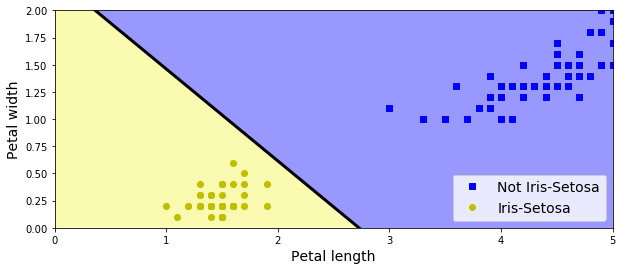

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

事实上，`Perceptron()` 相当于
```python
SGDClassifier(loss="perceptron", learning_rate="constant", eta0=1, penalty=None)
```

感知机的缺点：
- 判定边界（decision boundary）是线性的，所以感知机不能处理非线性的问题（著名的例子：感知机不能处理逻辑异或）
- 不能对每个所属类算出一个概率（这使得我们更倾向于使用Logisitic回归）

解决办法：引入多层感知机（Multi-Layer Perceptron, MLP)

## 1.3 多层感知机与反向传播（Back propagation）

MLP的结构：
- 输入层（input layer）
- 隐藏层（hidden layer）
- 输出层（output layer）

每层都可由多单个或多个LTU组成。除了输出层外每层都有一个bias neuron。当一个ANN有 $\geq 2$ 个隐藏层的时候就称为深度神经网络（DNN）

![MLP](./data/ann/MLP.png)

1986年，D.E.Rumelhart et al.发表了一篇文章，介绍了反向传播算法，可以用来训练MLP，其基本思想是：

> for each training instance the backpropagation algorithm first makes a prediction (forward pass), measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally slightly tweaks the connection weights to reduce the error (Gradient
Descent step).

- 前向传播：一层层的计算神经元直到最后的输出层
- 反向传播：测量误差，测量每个权重对误差的贡献程度
- 梯度下降：更新权值，减小误差

### 激活函数

为了使梯度下降算法可行，不能使用原先的step function，必须改变激活函数：

- **Sigmoid函数**（最常用）：$\sigma(z) = \dfrac{1}{1 + \exp(-z)}$
- 双曲正切函数：$\tanh(z) = 2\sigma(2z) - 1$
- ReLU函数：$\text{ReLU}(z) = \max (0,z)$

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

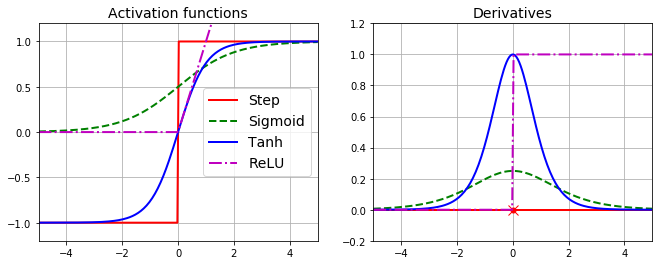

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

MLP通常用来做分类问题，每个输出对应着一个类别。这时输出层需要做一些改变，原来每个单独的激活函数替换成一个整体的Softmax函数，这样每个输出就是对应于每个类别的概率。

![MLP_classification](./data/ann/MLP_classification.png)

额外的参考资料：

- [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

# 2. 利用TensorFlow的高级API训练MLP

In [ ]:
import tensorflow as tf

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\q3026\\AppData\\Local\\Temp\\tmpojj97n81', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FA8C1DB4A8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\q3026\AppData\Local\Temp\tmpojj97n81

In [ ]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-12-14:40:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\q3026\AppData\Local\Temp\tmpojj97n81\model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-12-14:40:17
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9798, average_loss = 0.100138, global_step = 44000, loss = 12.6757


In [ ]:
eval_results

{'accuracy': 0.97979999,
 'average_loss': 0.10013769,
 'global_step': 44000,
 'loss': 12.675657}

In [ ]:
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
y_pred = list(y_pred_iter)
y_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\q3026\AppData\Local\Temp\tmpojj97n81\model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'class_ids': array([7], dtype=int64),
 'classes': array([b'7'], dtype=object),
 'logits': array([ -9.24409771,  -3.95008636,   4.70075607,   2.85423493,
        -12.14613438,  -9.70039654, -23.69737244,  22.82745361,
         -3.32769036,  -2.56774426], dtype=float32),
 'probabilities': array([  1.17896746e-14,   2.34780511e-12,   1.34176137e-08,
          2.11709938e-09,   6.47387282e-16,   7.47022666e-15,
          6.23052673e-21,   1.00000000e+00,   4.37487243e-12,
          9.35417022e-12], dtype=float32)}

# 3. 使用plain TensorFlow训练DNN

目标：建立一个深度神经网络实现MNIST的多分类任务

结构：
- 输入：MNIST image，28*28
- 隐藏层1：300个神经元
- 隐藏层2：100个神经元
- 输出：对应10个类别的概率

## 3.1 构建阶段

### 基本数据

In [ ]:
import tensorflow as tf

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

### 输入输出层

由于目前还不知道一个batch有多少个实例，所以输入和输出节点的shape设为None

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### 隐藏层

In [ ]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(z)
        else:
            return z

- `W`：权重矩阵
 - 用截断(truncated)正态分布初始化，避免出现太大的初始权重（太大的初始权重会减慢收敛速度）
 - 标准差为 $2/ \sqrt{n_{\text{inputs}}}$可以加快算法收敛速度(详见第11章）
- `b`：偏差
- `z`：加权求和的结果

### 建立DNN

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", 
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, "outputs")

- `logits`是神经网络在通过softmax之前的输出

~~实际上tensorflow提供了一系列函数用于建立神经元层，例如 `fully_connected()` 建立一个全连接层。~~（`contrib`这个模块的API即将被废弃了）

现在可以用 `tf.layers.dense()` 来代替 `fully_connected()` 

```python
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                          activation=tf.nn.relu)
```


### cost function

像第四章的Softmax Regression一样，采用交叉熵（corss entropy）来构造代价函数。

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

### 梯度下降

In [ ]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

### 模型评估

用top-1误差率计算准确率来评估

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### 初始化与模型保存

In [ ]:
init = tf.global_variables_initializer()
s

## 3.2 执行阶段

In [ ]:
n_epochs = 20
batch_size = 50

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./final_model/MNSIT_DNN.ckpt")

0 Batch accuracy: 0.88 Val accuracy: 0.9182
1 Batch accuracy: 0.94 Val accuracy: 0.9346
2 Batch accuracy: 0.94 Val accuracy: 0.9412
3 Batch accuracy: 0.88 Val accuracy: 0.9474
4 Batch accuracy: 0.98 Val accuracy: 0.9524
5 Batch accuracy: 0.94 Val accuracy: 0.9558
6 Batch accuracy: 1.0 Val accuracy: 0.9618
7 Batch accuracy: 0.94 Val accuracy: 0.9642
8 Batch accuracy: 0.96 Val accuracy: 0.9674
9 Batch accuracy: 0.94 Val accuracy: 0.9678
10 Batch accuracy: 0.92 Val accuracy: 0.97
11 Batch accuracy: 1.0 Val accuracy: 0.9712
12 Batch accuracy: 0.98 Val accuracy: 0.9692
13 Batch accuracy: 0.98 Val accuracy: 0.9702
14 Batch accuracy: 1.0 Val accuracy: 0.9712
15 Batch accuracy: 0.94 Val accuracy: 0.9718
16 Batch accuracy: 0.98 Val accuracy: 0.9728
17 Batch accuracy: 1.0 Val accuracy: 0.973
18 Batch accuracy: 1.0 Val accuracy: 0.9744
19 Batch accuracy: 0.98 Val accuracy: 0.9742
20 Batch accuracy: 1.0 Val accuracy: 0.9742
21 Batch accuracy: 1.0 Val accuracy: 0.975
22 Batch accuracy: 0.98 Val acc

## 3.4 回复模型与预测

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./final_model/MNSIT_DNN.ckpt")
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./final_model/MNSIT_DNN.ckpt


In [ ]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


----

# 习题

**习题1** 画出A异或B的神经网络示意图。

> ![xor](./data/ch10/xor.png)

**习题2** 为什么一般来说Logisitic回归模型要比单层感知机好？如何改变感知机使其和Logistic回归相同？

> 感知机不能处理非线性可分的数据集。感知机不能对每个每个类别分别做出预测。
>
> 改变：
> 1. 激活函数：使用logistic函数（或softmax函数如果有多个神经元）
> 2. 优化算法：使用随机梯度下降算法（或其他如交叉熵）

**习题3** 为什么在训练第一个MLP的时候，logistic激活函数（sigmoid）是很关键的一个成分？

> 为了使用梯度下降算法，激活函数的一阶导函数的性质很重要。step function除了跳跃点之外的导数都是0，梯度无法移动。而logistic函数每一点的导数都不为0.


**习题4** 说出几个常用的激活函数并画出大致图像

> - sigmoid函数
> - 双曲正切函数
> - ReLU函数

**习题5** 假设现在有一个MLP，输入层有10个神经元，一个隐藏层50个神经元，输出层3个神经元，激活函数是ReLU函数，问：

1. 输入矩阵 $\mathbf X$ 的维数
2. 隐藏层权重向量 $\mathbf W_h$ 的维数和偏差向量 $\mathbf b_h$ 的维数
3. 输出层权重向量 $\mathbf W_o$ 的维数和偏差向量 $\mathbf b_o$ 的维数
4. 输出矩阵 $\mathbf Y$ 的维数
5. 写出 $\mathbf Y$ 的函数

> 假设batch size是m：
> 1. $\mathbf X$: (m, 10)
> 2. $\mathbf W_h$: (10, 50), $\mathbf b_h$: (1, 50)
> 3. $\mathbf W_o$: (50, 3), $\mathbf b_o$: (1, 3)
> 4. $\mathbf Y$: (m, 3)
> 5. $\mathbf Y = \text{ReLU }[\text{ReLU }(\mathbf W_h \cdot X + b_h) \cdot W_o + b_o]$

**习题6** 

1. 在识别垃圾邮件的神经网络中，输出层有多少个神经元？采用什么激活函数？
2. 在识别MNIST手写字体的神经网络中，输出层有多少个神经元？采用什么激活函数？
3. 如果使用神经网络去预测第二章的房价，输出层有多少个神经元？采用什么激活函数？

> 1. 输出层一个神经元就够了，比如用它的值来表示是垃圾邮件的概率，这时激活函数应该用logistic函数
> 2. MNIST只有0-9共10个数字，所以需要十个神经元。由于是多分类任务，所以激活函数采用softmax函数，每个神经元的输出表示其属于某一类的概率
> 3. 一个神经元，不用激活函数，其值就是预测的房价

**习题7** 反向传播发算法的基本原理？和reverse-mode autodiff的区别？

> pass

**习题8** 列出MLP中的所有超参数。如果训练出来的MLP过拟合了，如何调参？

> MLP的超参数主要有：
> - 隐藏层的个数
> - 隐藏层中神经元的个数
> - 激活函数
>
> 如果过拟合可以尝试减少隐藏层或减少神经元个数。

**习题9** 在MNIST上训练一个较深的MLP，获得98%以上的准确率。同时加入保存和恢复checkpoints，添加summaries，画出学习曲线，用TensorBoard可视化等等。

In [ ]:
import tensorflow as tf

reset_graph()

In [ ]:
from datetime import datetime

# 模型保存路径
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_dir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_dir, name)

logdir = log_dir("mnist_dnn")
checkpoint_path = "./tmp/mnist_dnn.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./final_model/mnimnist_dnn.ckpt"

# shuffle batch
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

处理数据集

In [ ]:
# 处理数据集
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

构建阶段

In [ ]:
# 模型参数设置
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

# 输入输出
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# 神经网络
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation = tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidde2",
                             activation = tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
# 损失函数
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                            logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)
    
# 训练
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
# 评估
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

# 初始化
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

执行阶段

In [ ]:
# 执行参数设置
n_epochs = 10001
batch_size = 50
n_batches = len(X_train) // batch_size
best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    # 如果checkpoint文件存在，则从checkpoint恢复模型
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Trainning was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X:X_valid, y:y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch: ", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val*100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                # 如果loss一直没有减小就提前停止训练
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Trainning was interrupted. Continuing at epoch 1
INFO:tensorflow:Restoring parameters from /tmp/mnist_dnn.ckpt
Epoch:  5 	Validation accuracy: 95.060% 	Loss: 0.17863
Epoch:  10 	Validation accuracy: 96.580% 	Loss: 0.12965
Epoch:  15 	Validation accuracy: 97.240% 	Loss: 0.10552
Epoch:  20 	Validation accuracy: 97.520% 	Loss: 0.09247
Epoch:  25 	Validation accuracy: 97.640% 	Loss: 0.08137
Epoch:  30 	Validation accuracy: 97.920% 	Loss: 0.07585
Epoch:  35 	Validation accuracy: 97.960% 	Loss: 0.07200
Epoch:  40 	Validation accuracy: 98.000% 	Loss: 0.07021
Epoch:  45 	Validation accuracy: 98.000% 	Loss: 0.06836
Epoch:  50 	Validation accuracy: 98.080% 	Loss: 0.06705
Epoch:  55 	Validation accuracy: 98.240% 	Loss: 0.06662
Epoch:  60 	Validation accuracy: 98.080% 	Loss: 0.06853
Epoch:  65 	Validation accuracy: 98.100% 	Loss: 0.06985
Epoch:  70 	Validation accuracy: 98.140% 	Loss: 0.06959
Epoch:  75 	Validation accuracy: 98.220% 	Loss: 0.06829
Epoch:  80 	Validation accuracy: 98.220% 	Loss: 0.

在测试集上验证

In [ ]:
os.remove(checkpoint_epoch_path)

with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X:X_test, y:y_test})
    
accuracy_val

INFO:tensorflow:Restoring parameters from ./final_model/mnist_dnn.ckpt


0.97970003

可视化

In [ ]:
import pandas as pd
# csv 文件从tensorboard下载保存
accuracy_curve = pd.read_csv("./data/ch10/mnist_dnn_accuracy.csv")
loss_curve = pd.read_csv("./data/ch10/mnist_dnn_loss.csv")

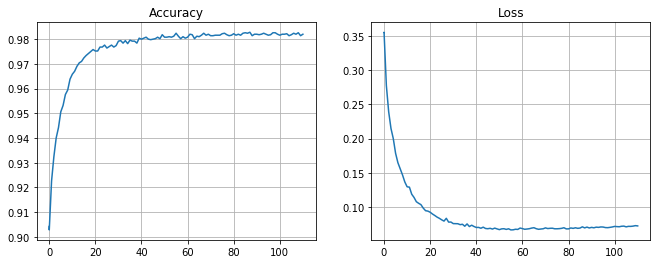

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(accuracy_curve.Step, accuracy_curve.Value)
plt.grid(True)
plt.title("Accuracy")

plt.subplot(122)
plt.plot(loss_curve.Step, loss_curve.Value)
plt.grid(True)
plt.title("Loss")

![mnist_dnn](./data/ch10/mnist_dnn.png)

# EOF